# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [21]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [22]:
# Load data (provided)
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

### 1.1 Display the dimension of the training and test sets. (5 marks)

In [23]:
print("Length of training set: \n{}".format(len(train_set)))
print("Dimensions of training set images: \n{}".format(train_image.shape))
print("Dimensions of training set labels: \n{}".format(train_label.shape))
print()
print("Length of test set: \n{}".format(len(test_set)))
print("Dimensions of test set images: \n{}".format(test_image.shape))
print("Dimensions of test set labels: \n{}".format(test_label.shape))

Length of training set: 
60000
Dimensions of training set images: 
(60000, 28, 28)
Dimensions of training set labels: 
(60000,)

Length of test set: 
10000
Dimensions of test set images: 
(10000, 28, 28)
Dimensions of test set labels: 
(10000,)


### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

<function matplotlib.pyplot.show(*args, **kw)>

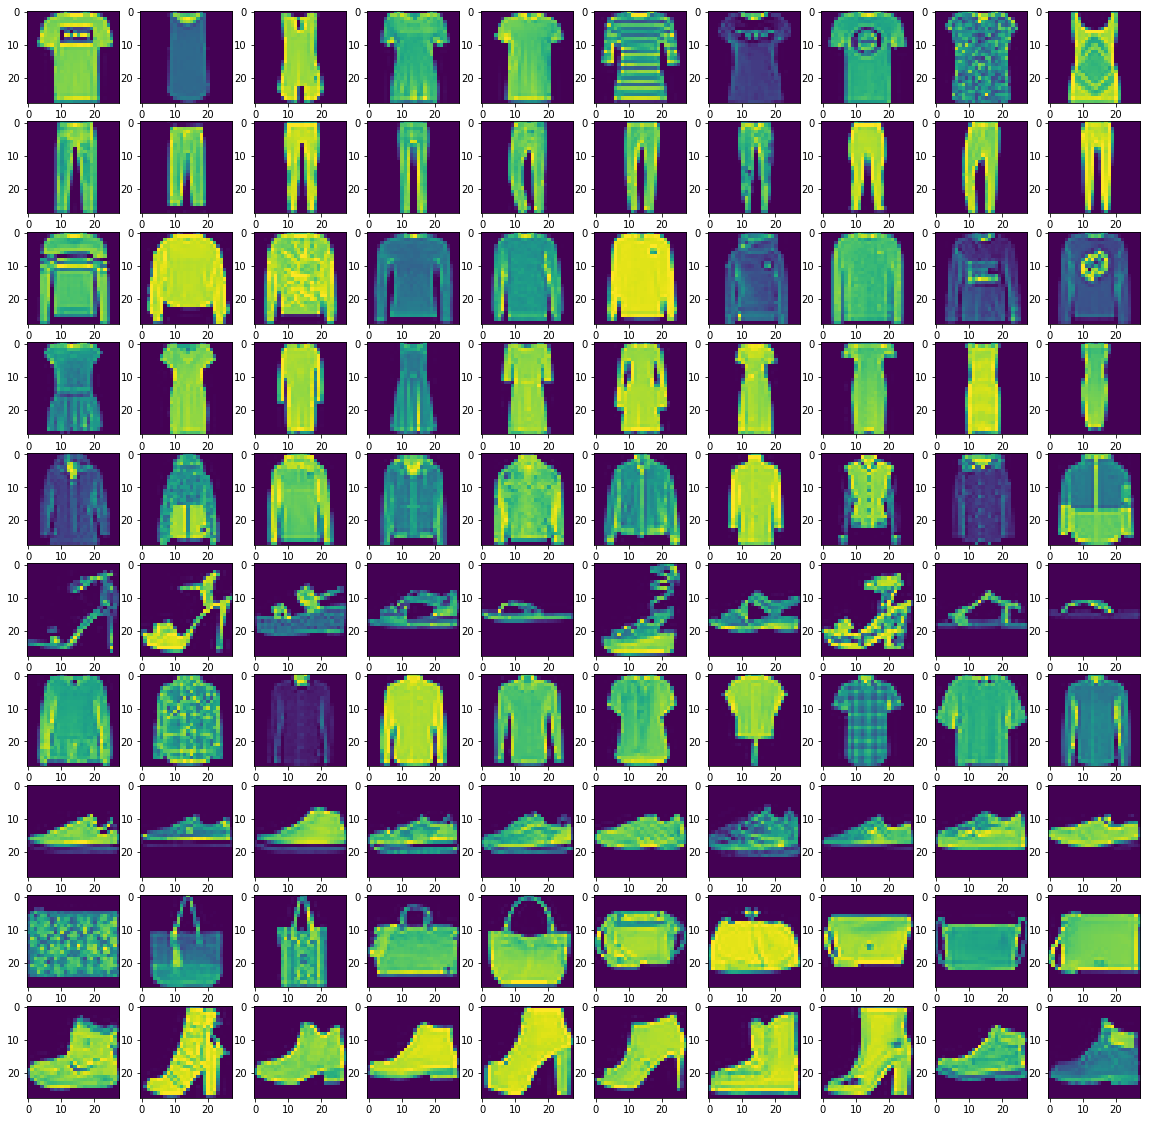

In [24]:
w = train_image[0].shape[0]
h = train_image[0].shape[1]
columns = 10
rows = len(np.unique(train_label))
fig = plt.figure(figsize=(20,20))

for i in range(0, columns*rows):
    label = i // columns
    indices = np.where(train_label == label)
    img = train_image[indices[0][i % columns]]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)

plt.show

### 1.3 Display the number of training samples for each class. (5 marks)

In [25]:
rows = len(np.unique(train_label))
unique, freq = np.unique(train_label, return_counts=True)
print(unique)
print(freq)

[0 1 2 3 4 5 6 7 8 9]
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

Yes, each class has 6000 observations in the training data. If the data were unbalanced, the model would minimise its loss function by specialising in classifying those classes which are more frequent in the training data. The resultant model would therefore overpredict those classes which are more frequent in the training data when run on new data.

## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.convoluted_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2), stride = 2),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2), stride = 2),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = (5,5)),
            nn.ReLU()
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(in_features = 120, out_features = 84),
            nn.ReLU(),
            nn.Linear(in_features = 84, out_features = 10),
            nn.LogSoftmax(dim=-1)
        )
    
    def forward(self, x):
        output = self.convoluted_layers(x)
        output = output.view(x.size(0), -1)
        output = self.fully_connected_layers(output)
        return output

### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [7]:
model = LeNet()
loss_function = nn.CrossEntropyLoss()
optimiser = optim.SGD(params = model.parameters(), lr = 0.01)
epochs = 10
batch_size = 120

### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

In [8]:
def shuffle(input_dataset, target_dataset):
    assert len(input_dataset) == len(target_dataset)
    p = np.random.permutation(len(input_dataset))
    return input_dataset[p], target_dataset[p]

def k_batches(x, y, k):
    assert len(x) == len(y)
    x = np.split(x, len(x)/batch_size)
    y = np.split(y, len(y)/batch_size)
    return x, y

In [9]:
def train(images, labels, shuffle_flag):
    loss_list = []
    epoch_loss_list = []
    epoch_no = []
    for epoch in range(epochs):
        # If shuffle flag is true, shuffle the dataset
        if shuffle_flag:
            images, labels = shuffle(images, labels)
        # Split train_image into batches
        image_batches, label_batches = k_batches(images, labels, batch_size)
        
        # Train and optimise for each batch in epoch
        for batch in range(len(image_batches)):
            image_batch = np.array(image_batches[batch])
            label_batch = np.array(label_batches[batch])
            
            image_batch = image_batch.reshape(image_batch.shape[0], 1, image_batch.shape[1], image_batch.shape[2])
            image_batch = torch.from_numpy(image_batch).float()
            
            label_batch = torch.LongTensor(label_batch)

            optimiser.zero_grad()
            output = model(image_batch)
            loss = loss_function(output, label_batch)
            loss_list.append(loss.item())
            loss.backward()
            optimiser.step()
        
        #Get loss for whole training dataset
        all_images = np.array(images)
        all_images = images.reshape(all_images.shape[0], 1, all_images.shape[1], all_images.shape[2])
        all_images = torch.from_numpy(all_images).float()
        all_labels = torch.LongTensor(labels)
        output = model(all_images)
        loss = loss_function(output, all_labels)
        epoch_loss_list.append(loss.item())
        epoch_no.append(epoch+1)
        
    plt.plot(epoch_no, epoch_loss_list)
    plt.title('Loss Function against Epoch Number')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

Training took 246.0829939842224 seconds


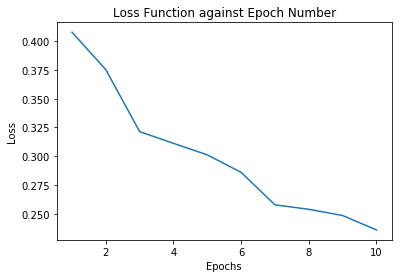

In [10]:
start = time.time()
train(train_image, train_label, True)
end = time.time()
print("Training took {} seconds".format(end - start))

### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [11]:
def test(images):
    images = np.array(images)
    images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2])
    images = torch.from_numpy(images).float()
    
    output = model(images)
    return output

In [12]:
start = time.time()
predictions = test(test_image).data.numpy()
prediction_values = np.argmax(predictions,axis=1)
end = time.time()
print("Testing took {} seconds".format(end - start))

Testing took 1.1243538856506348 seconds


### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [13]:
accuracy = metrics.accuracy_score(test_label, prediction_values)
print("Classification accuracy on the test set = {}".format(accuracy))

Classification accuracy on the test set = 0.886


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [14]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

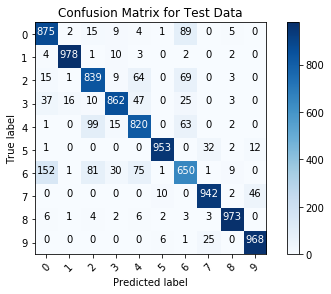

In [15]:
confusion = metrics.confusion_matrix(test_label, prediction_values)
plot_confusion_matrix(confusion, classes=np.unique(train_label), title='Confusion Matrix for Test Data')
plt.show()

## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

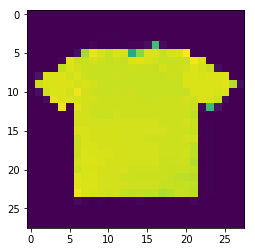

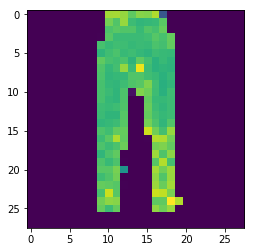

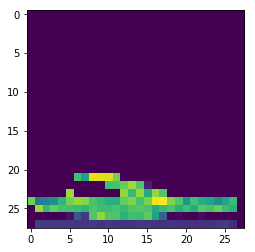

In [16]:
from PIL import Image
from PIL import ImageOps

tshirt = Image.open('tshirt.jpg').convert('L')
trousers = Image.open('trousers.jpg').convert('L')
sandal = Image.open('sandal.jpg').convert('L')

own_images = []
for image in tshirt,trousers,sandal:
    image = ImageOps.invert(image)
    image = image.resize((28,28))
    plt.figure()
    plt.imshow(image)
    plt.show()
    image = np.array(image)
    own_images.append(image)
own_images = np.array(own_images)

### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [19]:
real_image_predictions = test(own_images).data.numpy()
real_image_prediction_values = np.argmax(real_image_predictions,axis=1)
print("Ground truths for real images: \n{}".format(np.array([0, 1, 5])))
print("Predictions for real images: \n{}".format(real_image_prediction_values))

Ground truths for real images: 
[0 1 5]
Predictions for real images: 
[0 1 5]


### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?

Yes, for each of my three images, the model predicts the correct classification. However, the images selected were similar to those the model was trained on. The model would perform worse if the angles the images were taken from were different to those it was trained on. Because of the similarity of images in the same class in the training data, the model is overfitted to identifying each class from a specific angle. To improve the model in the real world, one could train it using labelled images of each class taken from different angles. One could also augment photos in the training data by inverting their greyscale intensities and adding blur. Using a validation set (defined as a random subset of the training data) to evaluate the model during training could also help. These would act to improve the model's generalised performance. 

Increasing sample size of the training data could also improve accuracy. The confusion matrix generated by running the test data through the model shows that tshirts, shirts and pullovers are often misclassified (which makes intuitive sense due to their similar shapes). More data to train the model on would better allow it to distinguish between these classes.

Other ideas for improving the model could be to alter the neural network architecture and alter the hyperparameters of the model (e.g. increase epochs, which I was unable to do due to time constraints given the hardware available to me). 